In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import pickle
import numpy as np
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torch.nn.functional as inter
import torchvision.models as models
import seaborn as sb
import plotly.io as pio
import plotly.graph_objs as go
import plotly.express as px


import os
from PIL import Image

In [3]:
class CustomDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_names = os.listdir(image_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):

        img_name = self.image_names[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image_rgb = Image.open(img_path)
        img_tensor = F.to_tensor(image_rgb)
        img_tensor_grey = F.rgb_to_grayscale(img_tensor, num_output_channels=1)
        img_resize = F.resize(img_tensor_grey, (200, 200))
        img_squeezed = img_resize.squeeze(0)
        img_flat = img_squeezed.view(-1, 200*200)
        img_flat_squeezed = img_flat.squeeze(0)

        return img_flat_squeezed

# Définir les répertoires de train et test
train_dir = '/content/drive/MyDrive/EA_MAP/transistor/transistor/train/good'
test_dir = '/content/drive/MyDrive/EA_MAP/transistor/transistor/test/good'
test_cut_dir = '/content/drive/MyDrive/EA_MAP/transistor/transistor/test/cut_lead'
test_bent_dir = '/content/drive/MyDrive/EA_MAP/transistor/transistor/test/bent_lead'
test_damaged_dir = '/content/drive/MyDrive/EA_MAP/transistor/transistor/test/damaged_case'
test_misplaced_dir = '/content/drive/MyDrive/EA_MAP/transistor/transistor/test/misplaced'

# Créer les datasets
train_dataset = CustomDataset(train_dir)
test_dataset = CustomDataset(test_dir)
test_cut_dataset = CustomDataset(test_cut_dir)
test_bent_dataset = CustomDataset(test_bent_dir)
test_damaged_dataset = CustomDataset(test_damaged_dir)
test_misplaced_dataset = CustomDataset(test_misplaced_dir)

# Créer les DataLoaders
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

In [4]:
n_front = 30000

map_boundaries = [i/n_front for i in range(n_front+1)]

def evaluation_boundary(paires, map_boundary):
  evaluation = []
  for i in range(len(paires)):
    evaluation.append(((2*int(paires[i][0] < map_boundary) - 1)*paires[i][1]+1)/2) # paires : liste avec toutes les paires évaluées par rapport a map_boundary
  return evaluation


def evaluate_whole_testset(list): # liste des paires
  percent_an = []
  percent_good = []
  for boundary in map_boundaries:
    percent_evaluation_good = np.sum(evaluation_boundary(list[1], boundary))/len(list[1])
    percent_evaluation_an = np.sum(evaluation_boundary(np.concatenate([list[2],list[3],list[4],list[5]]), boundary))/len(np.concatenate([list[2],list[3],list[4],list[5]]))
    percent_good.append([percent_evaluation_good,boundary])
    percent_an.append([percent_evaluation_an,boundary])
  return percent_good, percent_an


def plot_ROC(list):
  percent_good, percent_an = evaluate_whole_testset(list)
  plt.plot(np.ones(len(percent_an))-np.array([i[0] for i in percent_an]), np.array([i[0] for i in percent_good]), label='ROC curve')
  plt.title('ROC curve')
  plt.xlabel('false positives')
  plt.ylabel('true positives')
  plt.legend()
  plt.grid()
  plt.text(0.5, 0.15, f"AUC : {AUC(list)}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=12)


def AUC(list):
  percent_good, percent_an = evaluate_whole_testset(list)
  auc = 1 - np.trapz(np.ones(len(percent_an))-np.array([i[0] for i in percent_an]), np.array([i[0] for i in percent_good]))
  return auc

def AUC_30(list):
  percent_good, percent_an = evaluate_whole_testset(list)
  perc = []
  print(percent_an[7])
  for i in range(len(percent_an)):
    if 1-percent_an[i][0] < 0.3:
      perc.append(percent_an[i])
  percent_an = perc
  print(percent_an)
  percent_good = percent_good[0:len(percent_an)]
  tab1 = np.ones(len(percent_an))-np.array([i[0] for i in percent_an])
  tab2 = np.array([i[0] for i in percent_good])
  tab1 = [tab1[i] for i in range(len(tab1))]
  tab2 = [tab2[i] for i in range(len(tab2))]
  tab1.append(0.30)
  tab2.append(tab2[-1]+0.1)
  auc = (0.3 - np.trapz(tab1, tab2))/0.3 *0.8
  plt.plot(tab1, tab2)
  plt.show()
  return auc


In [5]:
def show_box_chart(title, name_folder, list):  # renvoie boîtes à moustache, liste des loss que l'on veut considérer, mettre loss du training set en premier (bleu)
  fig = go.Figure()
  fig.add_trace(go.Box(
        y=list[0][:,0],
        name=f'Loss from training set',
        marker_color='blue'
    ))

  for k in range(1, len(list)):
    fig.add_trace(go.Box(
        y=list[k][:,0],
        name=f'Loss {k}',
        marker_color='red'
    ))


  # Mettre à jour la disposition pour les afficher l'une en dessous de l'autre
  fig.update_layout(
      title=f'{title}',
      yaxis_title='Valeurs de perte',
      boxmode='group',  # Afficher les boxplots l'un en dessous de l'autre
      showlegend=True
  )
  pio.write_image(fig, f'/content/drive/MyDrive/EA_MAP/downloaded_data/{name_folder}/boxplot.png')
  fig.show()

## Test 1

Epochs : odd numbers between 1 and 11

LR : 0.001

Structure : [4096, 64]

Loss : MSE

[1.0, 0.00023333333333333333]
[[1.0, 0.0], [1.0, 3.3333333333333335e-05], [1.0, 6.666666666666667e-05], [1.0, 0.0001], [1.0, 0.00013333333333333334], [1.0, 0.00016666666666666666], [1.0, 0.0002], [1.0, 0.00023333333333333333], [1.0, 0.0002666666666666667], [1.0, 0.0003], [1.0, 0.0003333333333333333], [1.0, 0.00036666666666666667], [1.0, 0.0004], [1.0, 0.0004333333333333333], [1.0, 0.00046666666666666666], [1.0, 0.0005], [1.0, 0.0005333333333333334], [1.0, 0.0005666666666666667], [1.0, 0.0006], [1.0, 0.0006333333333333333], [1.0, 0.0006666666666666666], [1.0, 0.0007], [1.0, 0.0007333333333333333], [1.0, 0.0007666666666666667], [1.0, 0.0008], [1.0, 0.0008333333333333334], [1.0, 0.0008666666666666666], [1.0, 0.0009], [1.0, 0.0009333333333333333], [1.0, 0.0009666666666666667], [1.0, 0.001], [1.0, 0.0010333333333333334], [1.0, 0.0010666666666666667], [1.0, 0.0011], [1.0, 0.0011333333333333334], [1.0, 0.0011666666666666668], [1.0, 0.0012], [1.0, 0.0012333333333333332], [1.0, 0.00126666666666

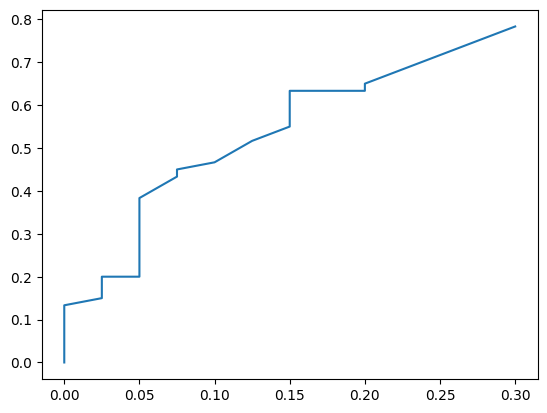

0.5977777777777779


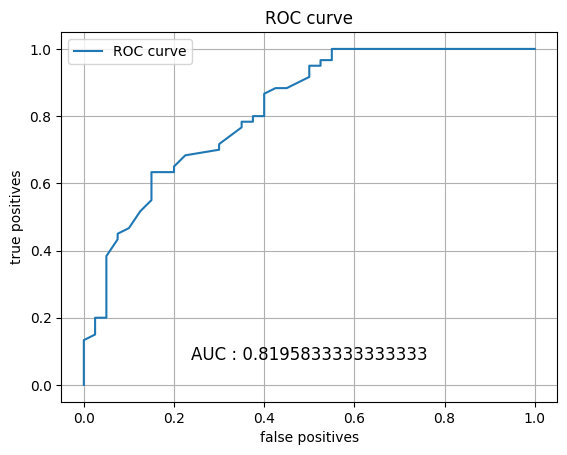

In [6]:
for k in range(1):
  name_folder = f'AE_MSELoss()_generation_7_epochs_10_lr_0.0001_BS_10_Structure_[10000, 5000, 100]'
  with open(f'/content/drive/MyDrive/EA_MAP/downloaded_data/{name_folder}/paire_norm.pkl', 'rb') as f:
    paire_norm = np.asarray(pickle.load(f))
  with open(f'/content/drive/MyDrive/EA_MAP/downloaded_data/{name_folder}/paire_good.pkl', 'rb') as f:
    paire_good = np.asarray(pickle.load(f))
  with open(f'/content/drive/MyDrive/EA_MAP/downloaded_data/{name_folder}/paire_bent.pkl', 'rb') as f:
    paire_bent = np.asarray(pickle.load(f))
  with open(f'/content/drive/MyDrive/EA_MAP/downloaded_data/{name_folder}/paire_damaged.pkl', 'rb') as f:
    paire_damaged = np.asarray(pickle.load(f))
  with open(f'/content/drive/MyDrive/EA_MAP/downloaded_data/{name_folder}/paire_cut.pkl', 'rb') as f:
    paire_cut = np.asarray(pickle.load(f))
  with open(f'/content/drive/MyDrive/EA_MAP/downloaded_data/{name_folder}/paire_misplaced.pkl', 'rb') as f:
    paire_misplaced = np.asarray(pickle.load(f))

  print(AUC_30([paire_norm, paire_good, paire_damaged, paire_cut, paire_bent, paire_misplaced]))
  plot_ROC([paire_norm, paire_good, paire_damaged, paire_cut, paire_bent, paire_misplaced])
  #plt.savefig(f'/content/drive/MyDrive/EA_MAP/downloaded_data/{name_folder}/ROC.png')
  plt.show()
  #show_box_chart(name_folder, name_folder, [paire_norm, paire_good, paire_damaged, paire_cut, paire_bent, paire_misplaced])



## Test 2

Epochs : 9

LR : ?

Structure : ?

Loss : MSE

In [7]:
for k in range(5):
  name_folder = f'AE_MSELoss()_epochs_{2*k + 1}_lr_0.001_BS_10_Structure_[4096, 64]'
  with open(f'/content/drive/MyDrive/EA_MAP/downloaded_data/{name_folder}/paire_norm.pkl', 'rb') as f:
    paire_norm = np.asarray(pickle.load(f))
  with open(f'/content/drive/MyDrive/EA_MAP/downloaded_data/{name_folder}/paire_good.pkl', 'rb') as f:
    paire_good = np.asarray(pickle.load(f))
  with open(f'/content/drive/MyDrive/EA_MAP/downloaded_data/{name_folder}/paire_bent.pkl', 'rb') as f:
    paire_bent = np.asarray(pickle.load(f))
  with open(f'/content/drive/MyDrive/EA_MAP/downloaded_data/{name_folder}/paire_damaged.pkl', 'rb') as f:
    paire_damaged = np.asarray(pickle.load(f))
  with open(f'/content/drive/MyDrive/EA_MAP/downloaded_data/{name_folder}/paire_cut.pkl', 'rb') as f:
    paire_cut = np.asarray(pickle.load(f))
  with open(f'/content/drive/MyDrive/EA_MAP/downloaded_data/{name_folder}/paire_misplaced.pkl', 'rb') as f:
    paire_misplaced = np.asarray(pickle.load(f))

  plot_ROC([paire_norm, paire_good, paire_damaged, paire_cut, paire_bent, paire_misplaced])
  plt.savefig(f'/content/drive/MyDrive/EA_MAP/downloaded_data/{name_folder}/ROC.png')
  plt.show()
  show_box_chart(name_folder, name_folder, [paire_norm, paire_good, paire_damaged, paire_cut, paire_bent, paire_misplaced])

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/EA_MAP/downloaded_data/AE_MSELoss()_epochs_1_lr_0.001_BS_10_Structure_[4096, 64]/paire_norm.pkl'

In [ ]:
for k in range(1):
  name_folder = f'AE_MSELoss()_generation_2_epochs_5_lr_0.0001_BS_7_Structure_[4096, 2048, 1024, 512, 256, 128, 64]'
  with open(f'/content/drive/MyDrive/EA_MAP/downloaded_data/{name_folder}/paire_norm.pkl', 'rb') as f:
    paire_norm = np.asarray(pickle.load(f))
  with open(f'/content/drive/MyDrive/EA_MAP/downloaded_data/{name_folder}/paire_good.pkl', 'rb') as f:
    paire_good = np.asarray(pickle.load(f))
  with open(f'/content/drive/MyDrive/EA_MAP/downloaded_data/{name_folder}/paire_bent.pkl', 'rb') as f:
    paire_bent = np.asarray(pickle.load(f))
  with open(f'/content/drive/MyDrive/EA_MAP/downloaded_data/{name_folder}/paire_damaged.pkl', 'rb') as f:
    paire_damaged = np.asarray(pickle.load(f))
  with open(f'/content/drive/MyDrive/EA_MAP/downloaded_data/{name_folder}/paire_cut.pkl', 'rb') as f:
    paire_cut = np.asarray(pickle.load(f))
  with open(f'/content/drive/MyDrive/EA_MAP/downloaded_data/{name_folder}/paire_misplaced.pkl', 'rb') as f:
    paire_misplaced = np.asarray(pickle.load(f))

  plot_ROC([paire_norm, paire_good, paire_damaged, paire_cut, paire_bent, paire_misplaced])
  plt.savefig(f'/content/drive/MyDrive/EA_MAP/downloaded_data/{name_folder}/ROC.png')
  plt.show()
  #show_box_chart(name_folder, name_folder, [paire_norm, paire_good, paire_damaged, paire_cut, paire_bent, paire_misplaced])



In [ ]:
for k in range(1):
  name_folder = f'AE_MSELoss()_generation_3_epochs_8_lr_1e-05_BS_6_Structure_[4096, 2048, 1024, 512, 256, 128, 64]'
  with open(f'/content/drive/MyDrive/EA_MAP/downloaded_data/{name_folder}/paire_norm.pkl', 'rb') as f:
    paire_norm = np.asarray(pickle.load(f))
  with open(f'/content/drive/MyDrive/EA_MAP/downloaded_data/{name_folder}/paire_good.pkl', 'rb') as f:
    paire_good = np.asarray(pickle.load(f))
  with open(f'/content/drive/MyDrive/EA_MAP/downloaded_data/{name_folder}/paire_bent.pkl', 'rb') as f:
    paire_bent = np.asarray(pickle.load(f))
  with open(f'/content/drive/MyDrive/EA_MAP/downloaded_data/{name_folder}/paire_damaged.pkl', 'rb') as f:
    paire_damaged = np.asarray(pickle.load(f))
  with open(f'/content/drive/MyDrive/EA_MAP/downloaded_data/{name_folder}/paire_cut.pkl', 'rb') as f:
    paire_cut = np.asarray(pickle.load(f))
  with open(f'/content/drive/MyDrive/EA_MAP/downloaded_data/{name_folder}/paire_misplaced.pkl', 'rb') as f:
    paire_misplaced = np.asarray(pickle.load(f))

  plot_ROC([paire_norm, paire_good, paire_damaged, paire_cut, paire_bent, paire_misplaced])
  plt.savefig(f'/content/drive/MyDrive/EA_MAP/downloaded_data/{name_folder}/ROC.png')
  plt.show()
  #show_box_chart(name_folder, name_folder, [paire_norm, paire_good, paire_damaged, paire_cut, paire_bent, paire_misplaced])

